In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
!unzip -q "/content/gdrive/My Drive/Colab Notebooks/vip2/NWPUvip.zip"

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#from __future__ import print_function
from keras.applications import ResNet50
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, load_img
import keras


res_conv = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

res_conv.summary()

Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 2s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________

In [0]:
train_dir='/content/NWPU-RESISC12/train'
validation_dir='/content/NWPU-RESISC12/test'
image_size = 224
nTrain = 6600
nVal = 1800

In [0]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20
 
train_features = np.zeros(shape=(nTrain, 7, 7, 2048))
train_labels = np.zeros(shape=(nTrain,12))
 
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)
i = 0
for inputs_batch, labels_batch in train_generator:
    features_batch = res_conv.predict(inputs_batch)
    train_features[i * batch_size : (i + 1) * batch_size] = features_batch
    train_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= nTrain:
        break
         
# save the features extracted from the training dataset to be passed to model.fit for training        
train_features = np.reshape(train_features, (nTrain, 7 * 7 * 2048))

Found 6600 images belonging to 12 classes.


In [0]:
validation_features = np.zeros(shape=(nVal, 7, 7, 2048))
validation_labels = np.zeros(shape=(nVal,12))

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

i = 0
for inputs_batch, labels_batch in validation_generator:
    features_batch = res_conv.predict(inputs_batch)
    validation_features[i * batch_size : (i + 1) * batch_size] = features_batch
    validation_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= nVal:
        break

# save the features extracted from the validation dataset to be passed to model.fit for training 
validation_features = np.reshape(validation_features, (nVal, 7 * 7 * 2048))

Found 1800 images belonging to 12 classes.


In [0]:
from keras import models
from keras import layers
from keras import optimizers
 
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=7 * 7 * 2048))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(12, activation='softmax'))

# model.compile(optimizer=optimizers.RMSprop(lr=2e-4),
#               loss='categorical_crossentropy',
#               metrics=['acc'])

model.compile(optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8),
             loss='categorical_crossentropy',
              metrics=['acc'])

In [0]:
history = model.fit(train_features,
                    train_labels,
                    epochs=40,
                    batch_size=batch_size,
                    validation_data=(validation_features,validation_labels))

Train on 6600 samples, validate on 1800 samples
Epoch 1/40
6600/6600 [==============================] - 21s 3ms/step - loss: 14.2416 - acc: 0.0914 - val_loss: 14.5325 - val_acc: 0.0833
Epoch 2/40
6600/6600 [==============================] - 18s 3ms/step - loss: 11.9625 - acc: 0.0895 - val_loss: 2.4838 - val_acc: 0.0844
Epoch 3/40
6600/6600 [==============================] - 18s 3ms/step - loss: 2.4930 - acc: 0.0882 - val_loss: 2.4673 - val_acc: 0.0944
Epoch 4/40
6600/6600 [==============================] - 18s 3ms/step - loss: 2.4815 - acc: 0.0873 - val_loss: 2.4793 - val_acc: 0.0844
Epoch 5/40
6600/6600 [==============================] - 18s 3ms/step - loss: 2.4743 - acc: 0.0826 - val_loss: 2.4853 - val_acc: 0.0833
Epoch 6/40
6600/6600 [==============================] - 18s 3ms/step - loss: 2.4718 - acc: 0.0950 - val_loss: 2.4321 - val_acc: 0.1067
Epoch 7/40
6600/6600 [==============================] - 18s 3ms/step - loss: 2.4528 - acc: 0.0964 - val_loss: 2.4331 - val_acc: 0.0889
Epoc

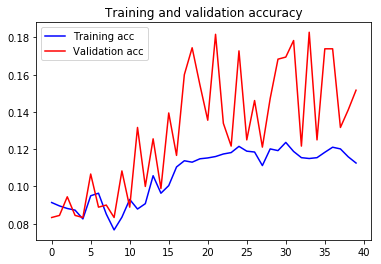

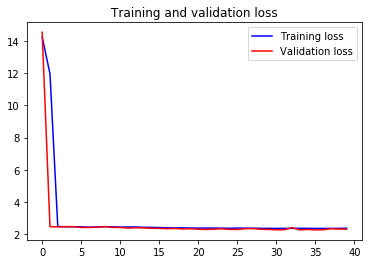

In [0]:
# Plot the accuracy and loss curves
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
# Evaluate the model
# Get the filenames from the generator
fnames = validation_generator.filenames

# Get the ground truth from generator
ground_truth = validation_generator.classes

# Get the label to class mapping from the generator
label2index = validation_generator.class_indices
 
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

In [0]:
# Get the predictions from the model using the generator
predictions = model.predict_classes(validation_features)
prob = model.predict(validation_features)

In [0]:
# Show the errors
errors = np.where(predictions != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),nVal))
#print("Accuracy = {}/{}".format((nVal-errors)/nVal)

In [2]:
res_conv1 = ResNet50(weights='imagenet',
                  include_top=True,
                  input_shape=(224, 224, 3))

res_conv1.summary()

102858752/102853048 [==============================] - 3s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
________________________